In [42]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt


MAX_DIFF_START = 40000
MAX_DIFF_END = 40000

START = 'start_dist'
END = 'end'
NAME = 'svk_cnv'
FILE = 'cnvs_SVK_hg38.tsv'

In [43]:
def approx_equal(row1, row2):
    """Defines equality for two rows/CNVs"""
    if abs(row1[START] - row2[START]) > MAX_DIFF_START:
        return False
    if abs(row1[END] - row2[END]) > MAX_DIFF_END:
        return False
    return True

In [44]:
def belongs_to_bucket(row, bucket, data):
    """Grouping function according to approximate equality"""
    for bucket_row in bucket:
        if approx_equal(data.loc[row], data.loc[bucket_row]):
            return True
    return False


In [45]:
def sort_into_buckets(data):
    buckets = []
    for i in data.index:
        bucket_matches = []
        for j in range(len(buckets)):
            if belongs_to_bucket(i, buckets[j], data):
                bucket_matches = bucket_matches + [j]
        if len(bucket_matches) == 0:
            # row i does not belong to any existing bucket, create a new bucket for it
            buckets = buckets + [[i]]
        elif len(bucket_matches) == 1:
            # row i belongs to one and only one bucket, add row i to it
            buckets[bucket_matches[0]] = buckets[bucket_matches[0]] + [i]
        else:
            # row i belongs to more than one bucket, merge the buckets into one big bucket
            new_bucket = sum([buckets[j] for j in bucket_matches], []) + [i]
            updated_buckets = [buckets[j] for j in ( set(range(len(buckets))) - set(bucket_matches) )] + [new_bucket]
            buckets = updated_buckets
    return buckets 

In [46]:
# load data and filter for NEXTSEQ, group by chromosome
data_all  = pd.read_csv(FILE, sep = '\t')
data_nextseq = data_all[data_all.loc[:,'machine']=='NEXTSEQ']
data = data_nextseq[data_nextseq['level']>0][['chromosome',START,END]].groupby(['chromosome',START,END]).size().reset_index()
data['bucket_number'] = 0

In [47]:
# bucket/group similar CNVs
chromosome_values = set(data['chromosome'])
buckets = []
for c in chromosome_values:
    print('chromosome', c)
    buckets = buckets + sort_into_buckets(data[data.loc[:,'chromosome']==c])

chromosome 0
chromosome 1
chromosome 2
chromosome 3
chromosome 4
chromosome 5
chromosome 6
chromosome 7
chromosome 8
chromosome 9
chromosome 10
chromosome 11
chromosome 12
chromosome 13
chromosome 14
chromosome 15
chromosome 16
chromosome 17
chromosome 18
chromosome 19
chromosome 20
chromosome 21
chromosome 22


In [48]:
# assign bucket numbers
for j in range(len(buckets)):
    for i in buckets[j]:
        data.loc[i,'bucket_number'] = j

In [49]:
# group by bucket number and chromosome, filter the most frequent groups
data_grouped_min = data.groupby(['chromosome','bucket_number']).agg({START: ['min']})
data_grouped_max = data.groupby(['chromosome','bucket_number']).agg({END: ['max']})
data_grouped_cnv_counts = data.groupby(['chromosome','bucket_number']).agg({0: ['sum']})

data_grouped_1 = data_grouped_min.join(data_grouped_max, on=['chromosome','bucket_number'])
data_grouped = data_grouped_1.join(data_grouped_cnv_counts, on=['chromosome','bucket_number'])

data_grouped = data_grouped.droplevel(level=0, axis=1)
data_grouped['freq'] = data_grouped['sum'] / data_grouped['sum'].sum()
# data_grouped['freq'] = data_grouped[0] / data_grouped[0].sum()

frequent_cnv = data_grouped[data_grouped['freq'] > 0.01]
frequent_cnv

min        max  sum      freq
chromosome bucket_number                                     
0          47             175420000  175780000   34  0.013189
5          459            168260000  168600000  175  0.067882
7          550              2260000    2640000   83  0.032196
10         777            134320000  134720000   67  0.025989
13         872             43800000   44260000   26  0.010085
14         899             22760000   23080000   39  0.015128
           906             32020000   32420000   45  0.017455
18         1043            52260000   52640000   29  0.011249
21         1096            22280000   22580000  126  0.048875
22         1127             6420000    8160000   39  0.015128

In [50]:
# save data
data_grouped.to_csv('./' + NAME + '_grouped.tsv', sep='\t')
frequent_cnv.to_csv('./' + NAME + '_most_freq.tsv', sep='\t')

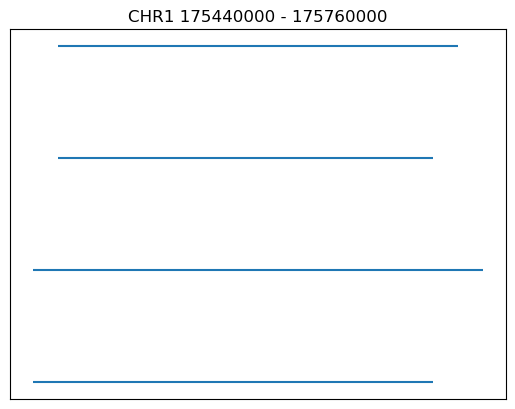

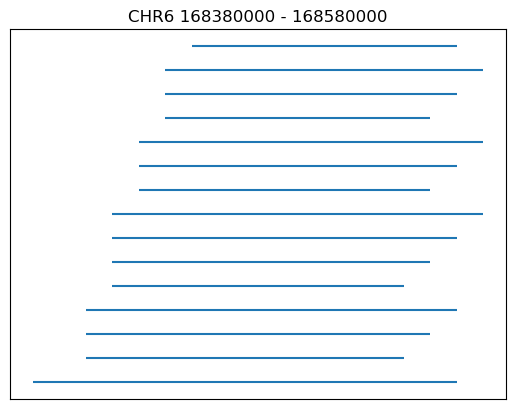

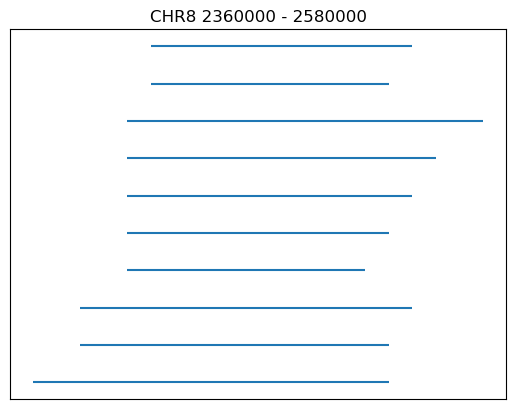

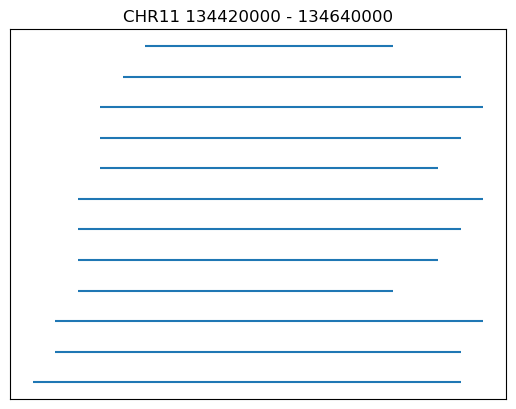

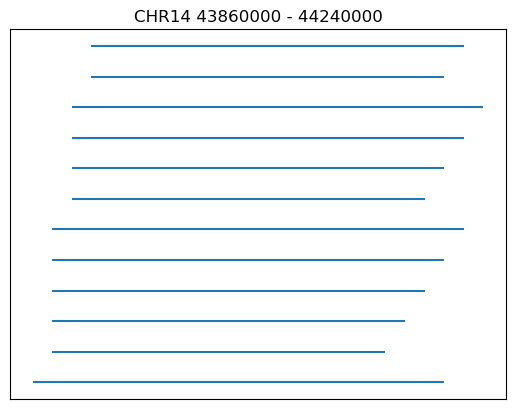

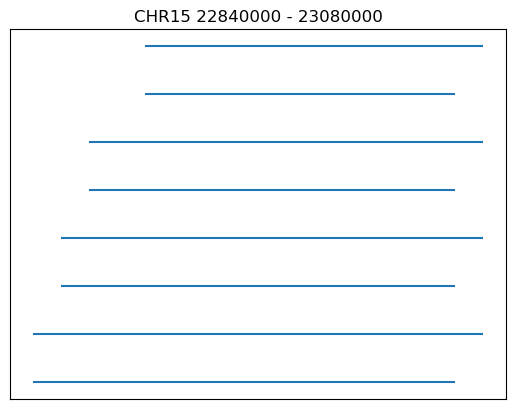

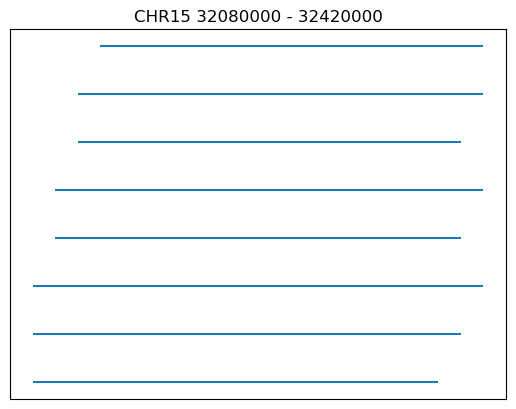

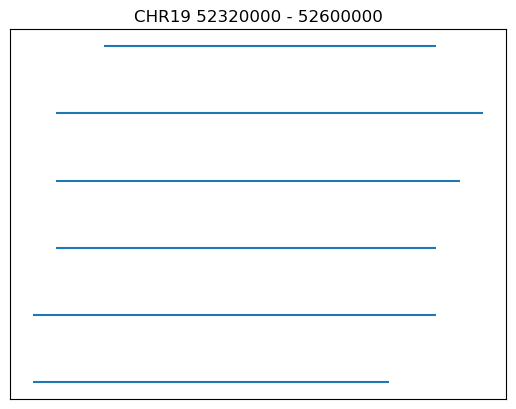

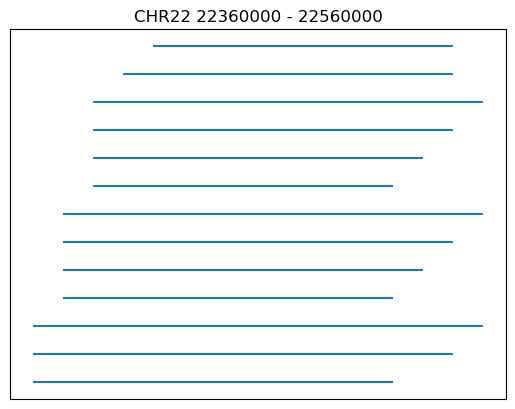

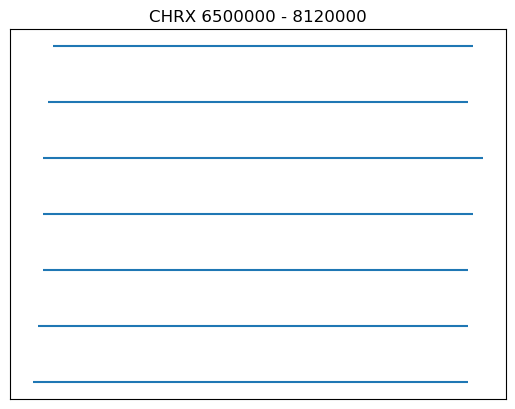

In [51]:
# export the most frequent buckets as pdf 
pdf = matplotlib.backends.backend_pdf.PdfPages('./' + NAME + '.pdf')

for i in frequent_cnv.index.get_level_values('bucket_number'):
    idx = 1    
    fig, ax = plt.subplots(1)
    for index, row in data.iterrows():   
        if row['bucket_number'] == i:
            ax.hlines(y = idx, xmin = row[START], xmax = row[END])            
            if row['chromosome'] == 22:
                plt.title('CHR' + str('X') + ' ' + str(row[START]) + ' - ' + str(row[END])) 
            else:    
                plt.title('CHR' + str( row['chromosome']+1) + ' ' + str(row[START]) + ' - ' + str(row[END])) 
            ax.set_xticks([])
            ax.set_yticks([])
            
            idx = idx +1
    pdf.savefig(fig)      
pdf.close()